In [8]:
%matplotlib inline 
import torch 
import numpy as np
import matplotlib.pyplot as plt

from pyvi.utils import GMMLossFunc as lf
from pyvi.utils import HelperFunc as hf
from pyvi.utils import Gaussian1D


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

print(f"Using {device} device")

#plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


## 1. Gaussian distribution

Data model: $$y \sim \mathcal{N}(\mu, \sigma^2)$$

Prior: 
\begin{align*} \mu|\sigma^2 &\sim \mathcal{N}(\mu_0, \sigma^2/\kappa), \: \kappa > 0 \\ 
\sigma^2 &\sim \text{InverseGamma}(\alpha, \beta), \: \alpha > 0, \beta > 0 \end{align*}

Observations: $$\mathbf{y} = \{y_1, y_2,\dots,  y_n\},\: n\geq 1$$

Problem: approximate $p(\theta|\mathbf{y})$, where $\theta = (\mu, \sigma^2)$

### 1. Prior 

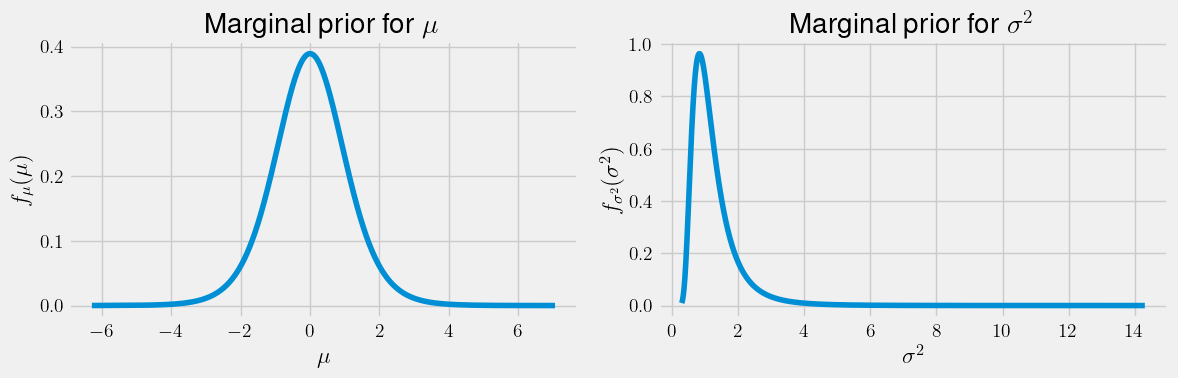

In [9]:
params_mu = {'mu_0': 0.0, 'kappa': 1.0}
params_sigma2 = {'alpha': 5.0, 'beta': 5.0}

prior = Gaussian1D.GaussianInverseGamma(params_mu, params_sigma2)

n_prior =  10000
theta = prior.sample((n_prior,))
theta = theta.sort(dim=0).values


fig = plt.figure(figsize=(12, 4))

fig.add_subplot(121)
plt.plot(theta[...,0], prior.mu_marginal.log_prob(theta[...,0]).exp())
plt.xlabel(r'$\mu$')
plt.ylabel(r'$f_\mu(\mu)$')
plt.title("Marginal prior for " + r'$\mu$')

fig.add_subplot(122)
plt.plot(theta[...,1], prior.sigma2.log_prob(theta[...,1]).exp())
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$f_{\sigma^2}(\sigma^2)$')
plt.title("Marginal prior for " + r'$\sigma^2$')

plt.tight_layout()
plt.show()

### 2. Simulator

In [10]:
simulator = Gaussian1D.Gaussian1DSimulator(theta=theta)
n_obs = 1
y = simulator.sample((n_obs,))
print(y.shape)

torch.Size([10000, 1])


### 1.3 Prior predictive distribution

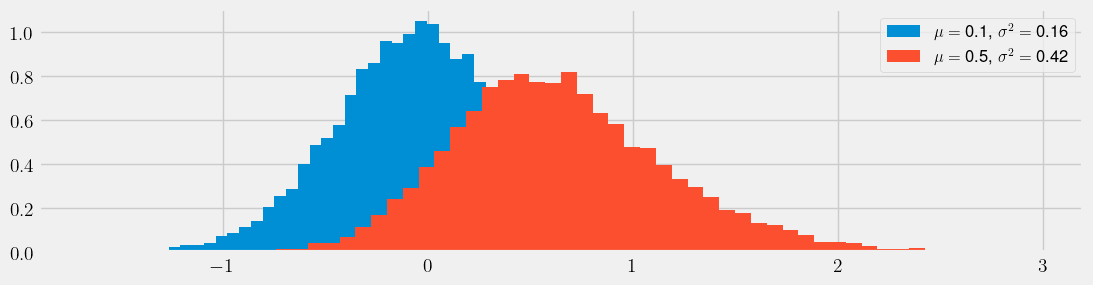

In [4]:
params_mu = {'mu_0': 0.0, 'kappa': 1.0}
params_sigma2 = {'alpha': 5.0, 'beta': 1.0}

prior = Gaussian1D.GaussianInverseGamma(params_mu, params_sigma2)

n_prior, n_obs = 2, 10000
theta = prior.sample((n_prior,))

model = Gaussian1D.Gaussian1DSimulator(theta)

y = model.sample((n_obs,))
y = y.sort(dim=0).values


plt.figure(figsize=(12, 3))
[plt.hist(y[i], bins=50, density=True, label=r'$\mu= $ ' + str(theta[i,0].round(decimals=1).numpy()) +\
          r', $\sigma^2= $ ' + str(theta[i,1].round(decimals=2).numpy())
          ) for i in range(y.shape[0])]


plt.legend(fontsize=12,  markerscale=.5)
plt.show()

### 1.5. Training

Epoch 1 Loss 2.0108464002013204 

Epoch 2 Loss 0.7703881464205682 

Epoch 3 Loss 0.007969236045703291 

Epoch 4 Loss -0.3827328429032117 

Epoch 5 Loss -0.6837115045196377 

Epoch 6 Loss -1.023544052820839 

Epoch 7 Loss -1.4440732974319253 

Epoch 8 Loss -1.6691412343419156 

Epoch 9 Loss -1.8504640926129186 

Epoch 10 Loss -1.9997963483873755 

Epoch 11 Loss -2.0555130219370126 

Epoch 12 Loss -2.111404996220814 

Epoch 13 Loss -2.2288470684048254 

Epoch 14 Loss -2.321080327176396 

Epoch 15 Loss -2.3728403288550677 

Epoch 16 Loss -2.3973030620309523 

Epoch 17 Loss -2.4607678969081492 

Epoch 18 Loss -2.518549101230595 

Epoch 19 Loss -2.558479416598892 

Epoch 20 Loss -2.558525104023842 

Epoch 21 Loss -2.5569891351288185 

Epoch 22 Loss -2.607679204238055 

Epoch 23 Loss -2.623319178007357 

Epoch 24 Loss -2.645972962979972 

Epoch 25 Loss -2.625375930700917 

Epoch 26 Loss -2.6272657030053437 

Epoch 27 Loss -2.6413209715378003 

Epoch 28 Loss -2.6683390095466746 

Epoch 29 Los

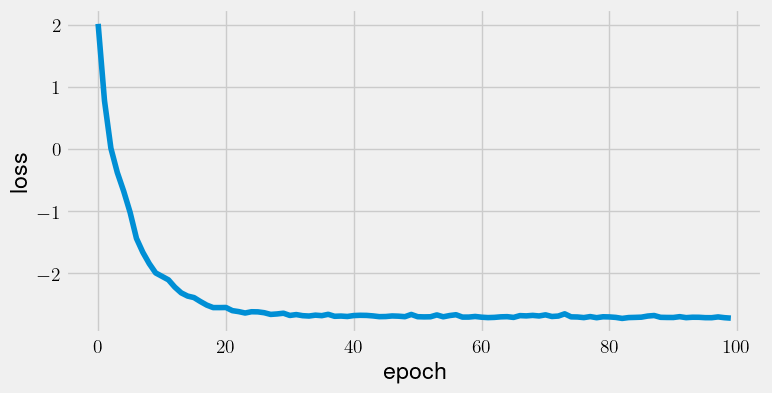

In [5]:
#Explicitly provided seeds for training process
random_seed = 12345  
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, batchsize = 5000, 400, 200

# sample parameter values from the specified prior
params_mu = {'mu_0': 0.0, 'kappa': 1.0}
params_sigma2 = {'alpha': 5.0, 'beta': 5.0}

prior = Gaussian1D.GaussianInverseGamma(params_mu, params_sigma2)
Theta_train = prior.sample((n_prior,))

# draw samples from the simulator conditioned on parameter values
simulator = Gaussian1D.Gaussian1DSimulator(Theta_train)
Y_train = simulator.sample((n_obs,))

# put variance on log-scale for improved training
Theta_train[...,1] = Theta_train[...,1].log()

# create a combined dataset and data loader
data_train = torch.utils.data.TensorDataset(Y_train, Theta_train)
data_loader = torch.utils.data.dataloader.DataLoader(data_train, batch_size=batchsize, shuffle=True)


#========================================================
#   Gaussian mixture net with data sorting
#========================================================
gmmnet = hf.MultivariateGaussianMDN(input_size=n_obs, dim=2, K=2, hd=128, sort=True).to(device)
loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # train DNN model
gmmnet = hf.nn_optimizer(model=gmmnet, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=1e-4,
                       eps=0.1, 
                       max_epochs=100,
                       verbose=True,
                       echo_after=1,
                       path='trained_models/gaussian1d/gaussian_mean_logvar_sorted.pt'
                      )

#========================================================
#   Gaussian mixture net with data no sorting
#========================================================
# gmmnet_notsorted = hf.MultivariateGaussianMDN(input_size=n_obs, dim=2, K=2, hd=128, sort=False).to(device)
# loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # # train DNN model
# gmmnet_notsorted = hf.nn_optimizer(model=gmmnet_notsorted, 
#                        data_loader=data_loader,
#                        loss_fn=loss_fn,
#                        learning_rate=1e-4,
#                        eps=0.1, 
#                        max_epochs=100,
#                        verbose=True,
#                        echo_after=10,
#                        path='trained_models/gaussian1d/gaussian_mean_logvar_not_sorted.pt'
#                       )

#gmmnet = torch.load('trained_models/gaussian1d/gaussian_mean_logvar_sorted_k1.pt')

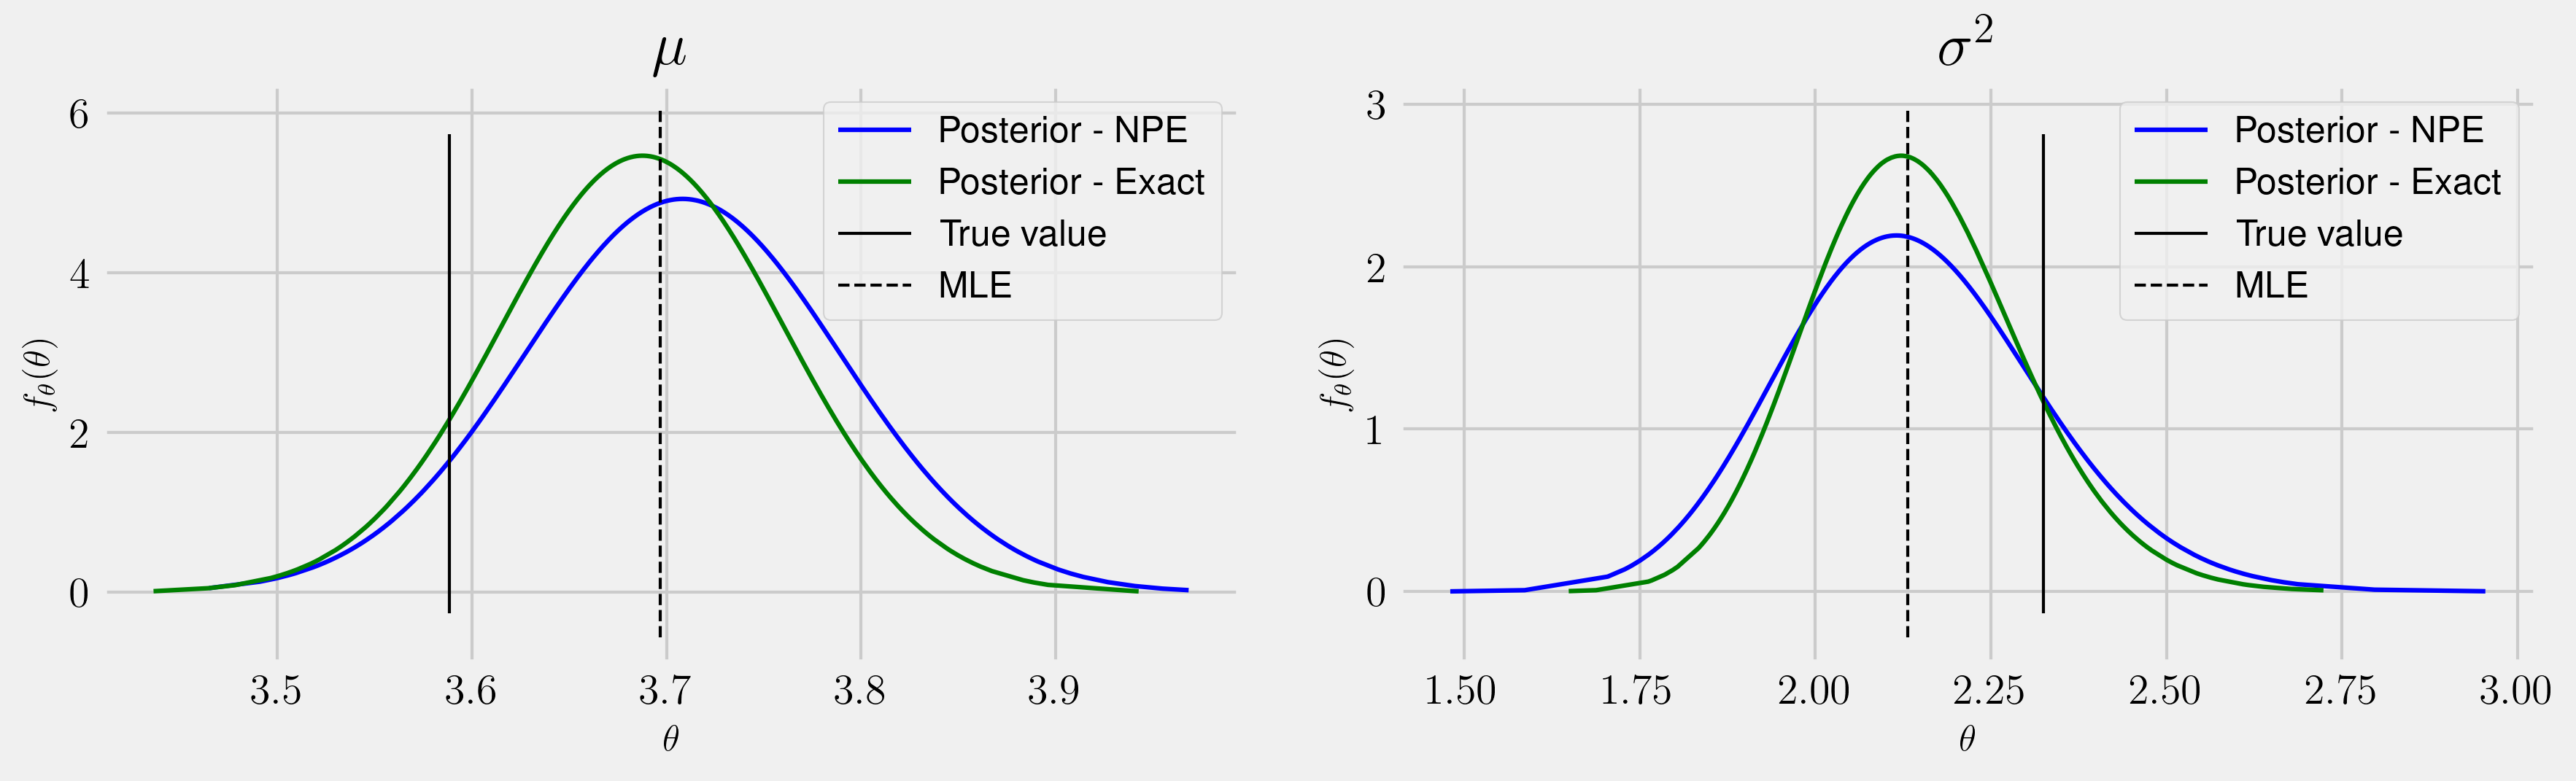

In [6]:
theta = prior.sample()
yobs = Gaussian1D.Gaussian1DSimulator(theta.unsqueeze(0)).sample((n_obs,)).squeeze()

# with sorting
fig = Gaussian1D.posterior_compare(gmmnet, prior, yobs, theta, show_prior=False, dpi=300)
fig.savefig(fname="figures/gaussian1d_.png")

# no sorting
# fig1 = Gaussian1D.posterior_compare(gmmnet_notsorted, prior, yobs, theta, show_prior=False, dpi=300)
# fig1.savefig(fname="figures/gaussian1d_notsorted_c.png")


### Simulation-based calibration check

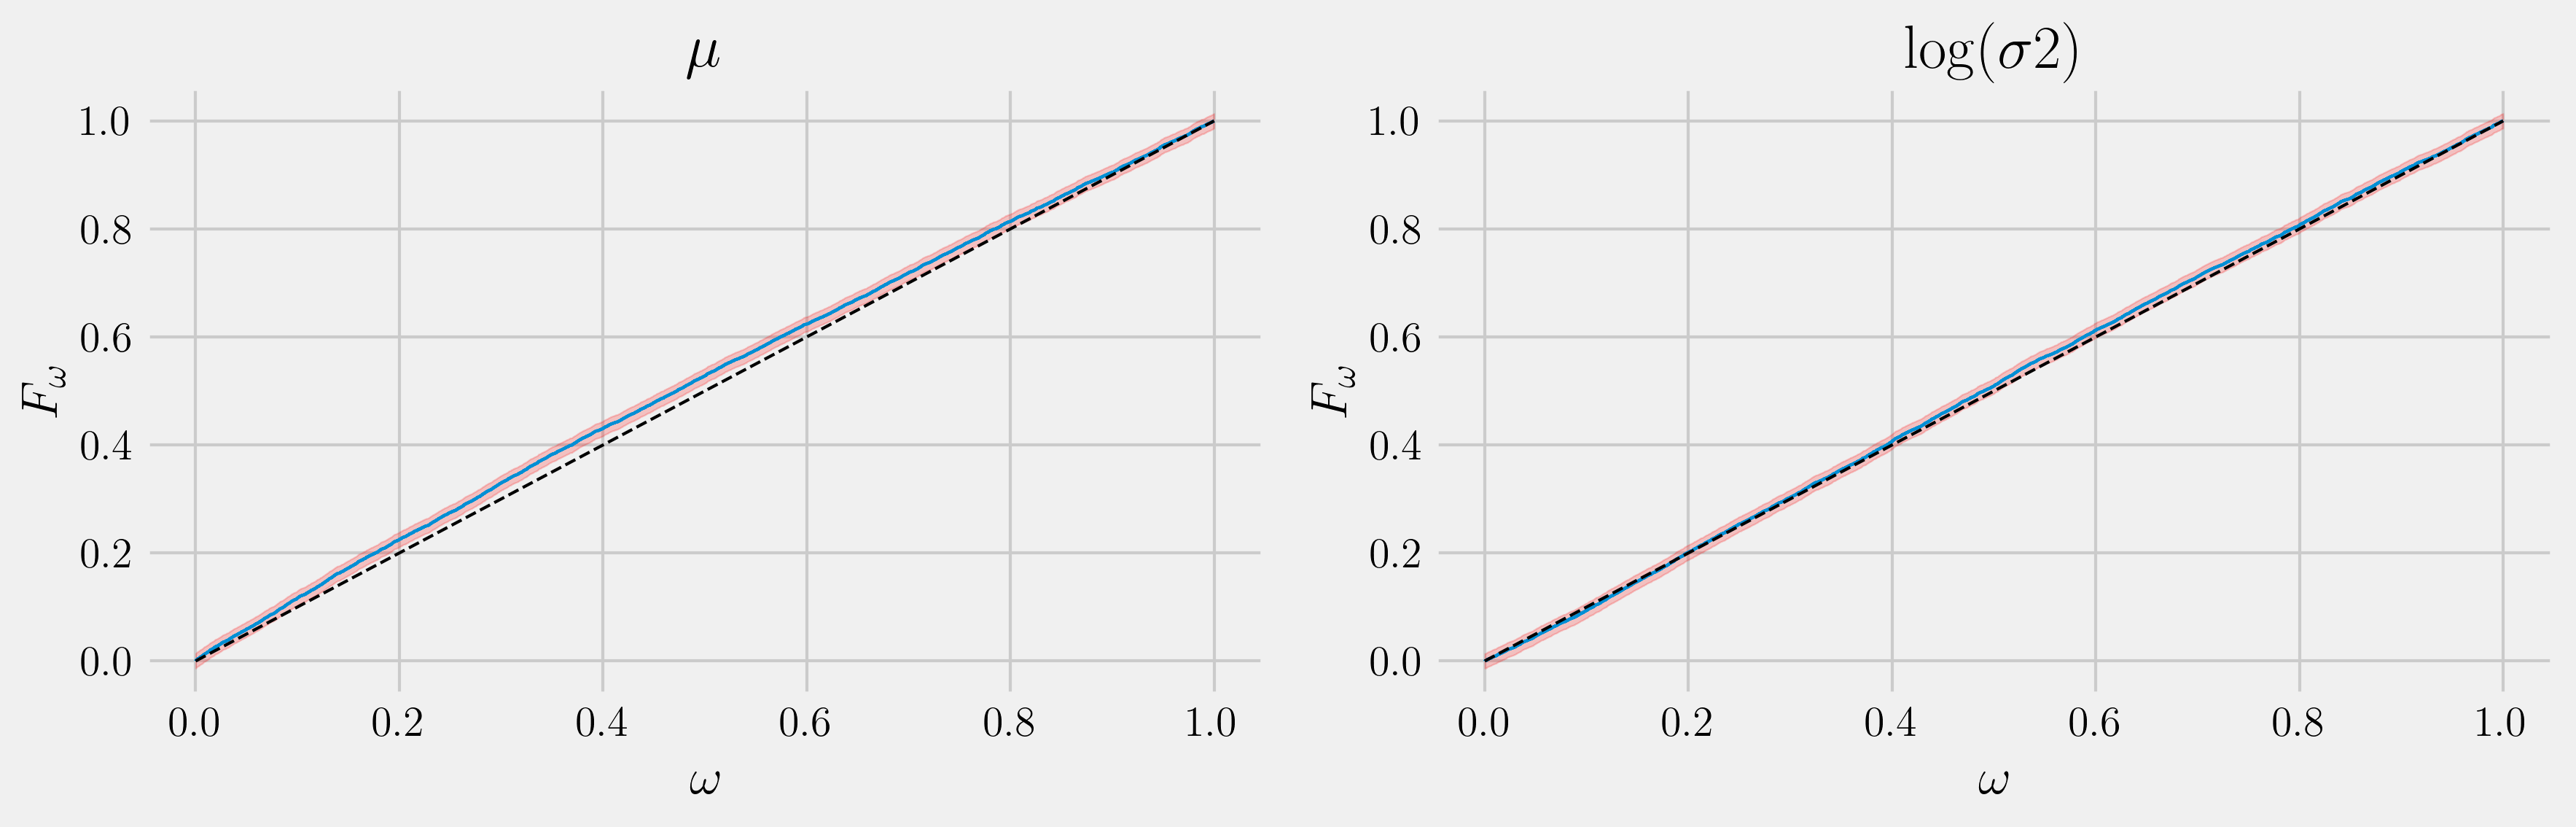

In [7]:
# with sorting
f = hf.sbc_gaussian(gmmnet, prior, Gaussian1D.GenerateSimulator, n_obs, 10000, ecdf=True, ecdf_diff=False, logscale=[1], dpi=300)
f.savefig(fname="figures/gaussian1d_sbc.png")
# with no sorting
#f1 = hf.sbc_gaussian(gmmnet1, prior, Gaussian1D.GenerateSimulator, n_obs, 10000, ecdf=True, ecdf_diff=False, logscale=[1])